In [71]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared,DotProduct
from sklearn.datasets import fetch_mldata

## MAUNA LOA

In the following lines we will present our particular approach to address the Mauna Loa $CO_{2}$ regression problem. It is a clear example of how special covariance functions (kernels) can be designed to achieve various useful effects.

The data consists of the monthly average atmospheric $CO_{2}$ concentrations (in parts per million by volume (ppmv)) collected at the Mauna Loa Observatory in Hawaii, since 1958. The objective is to model the $CO_{2}$ concentration as a function of the time x. Thus, we are working in a time series environment.

All along the notebook we will use the gaussian Processes implementation provided by scikit learn since after some attemps using the Gaussian processes implementation from scratch made at class gives rise to results less accurated (probably my fault). 

A reasonable way to start the modelling process is identifying the different components of our data. Classic deterministic analysis of time series suggests that every function should be decomposed in all or some of this features: trend, seasonal variations, term irregularities and noise. Once this first step is accomplished, the kernel and, therefore, hyperparameter selection and combination should take care of these individual properties in order to provide a well fit to the data.


However, before starting the process of solving the regression problem and in order to get a deeper insight of how we can address it, we briefly present different examples of **covariances functions** and some of the structures which can be obtained by combining them and that will allow us to solve the Mauna Loa problem.

## Covariance Functions

As said in the lectures the covariance function (kernel) is the driving factor in a Gaussian process predictor as it specifies which functions are likely under the GP prior, which in turn determines the generalization properties of the model. In other words, choosing a useful kernel is equivalent to learning a useful representation of the input as it encodes our assumptions about the function which we wish to learn.

We are going to present some of the commonly-used examples and how we can combine them to generate different kins of structures .

**SQUARED EXPONENTIAL**

The SE kernel has become the de-facto default kernel for GPs. Also known as the Radial Basis Function or the Gaussian Kernel. It has already been introduced in the lectures,and has the form:

\begin{align}
k_{SE}(x,x') = \sigma^2_{f} exp\bigg(-\frac{({x - x'})^{2}}{2 \ell^{2}} \biggr) 
\end{align}


This covariance function has some nice properties, such as infinitely differentiability, which means that the GP has mean square derivatives of all orders, and thus is very smooth. It has two parameters:

-The lengthscale $\ell$ determines the length of the 'wiggles' in a function. In general, we won't be able to extrapolate more than $\ell$  units away from your data. Informally can be thought of as roughly the distance you have to move in input space before the function value can change significantly.

-The output variance $\sigma^2_{f}$ determines the average distance of your function away from its mean. Every kernel has this parameter out in front; it's just a scale factor.

Below we show some GP priors generated with the SE kernel with different hyperparameters values. The first plot shows priors generated with $(l, \sigma^{2}_{f} ) = (1, 1)$. The function is very smooth and the average distance of the functions away from its mean is quite controlled, thus the variance term is small. In the next plot the length-scale has been shortened and the priors are more wiggled and oscillate more quickly, $(l, \sigma^{2}_{f} ) = (3.0, 0.1)$. At the same time the variance is larger and consequently the range of the priors increases.


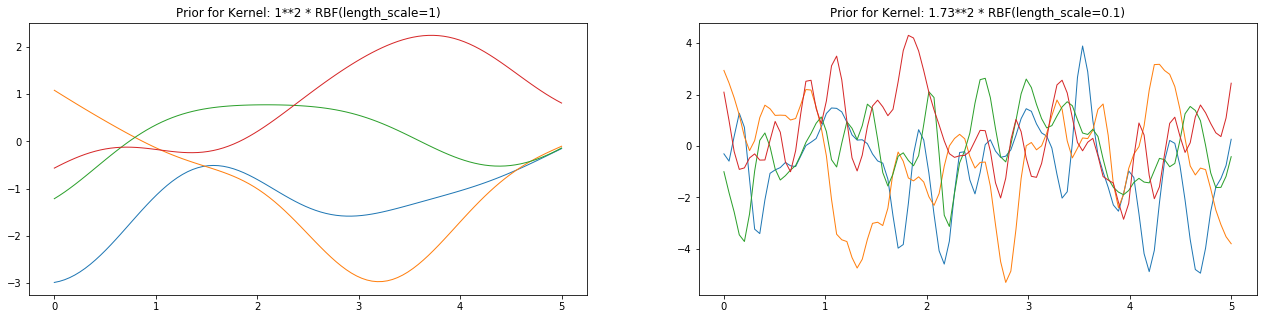

In [45]:
kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           3.0 * RBF(length_scale=0.1, length_scale_bounds=(1e-1, 10.0))]
i=0
f,axarr = plt.subplots(1, 2,figsize=(22,5))
for fig_index, kernel in enumerate(kernels):
    gp = GaussianProcessRegressor(kernel=kernel)
    # Plot prior
    #plt.figure(fig_index, figsize=(8, 8))
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    y_samples = gp.sample_y(X_[:, np.newaxis], 4)
    axarr[i].plot(X_, y_samples, lw=1)
    axarr[i].set_title("Prior for Kernel: "+str(kernel), fontsize=12)
    i+=1
plt.show()

Note that for a smaller lengthscale the prior it wiggles more.

**RATIONAL QUADRATIC**

The Rational quadratic (RQ) covariance function is

\begin{align}
k_{RQ}(\tau)= \sigma^{2}_{f} \bigg(1+ \frac{\tau^{2}}{2\alpha \ell^{2}}\biggr)^{-\alpha}
\end{align}

with $\alpha$, $\ell > 0$ can be seen as an infinite sum of squared exponential (SE) covariance functions with different characteristic length-scales. So, GP priors with this kernel expect to see functions which vary smoothly across many lengthscales. The parameter $\alpha$ determines the relative weighting of large-scale and small-scale variations. When $\alpha \to \infty$, the RQ is identical to the SE. Note that the process is infinitely mean-squared differentiable for every $\alpha$.

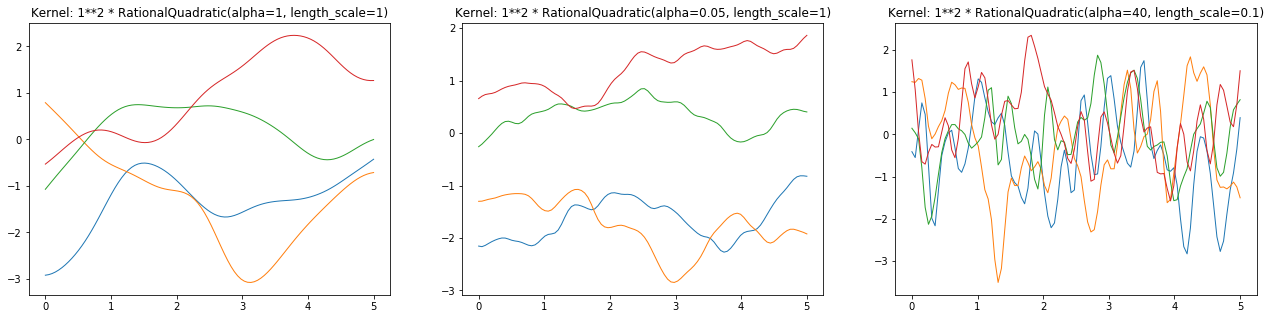

In [52]:
kernels = [1.0*RationalQuadratic(length_scale=1.0, alpha=1),
           1.0*RationalQuadratic(length_scale=1.0, alpha=0.05),
          1.0*RationalQuadratic(length_scale=0.1, alpha=40)]
i=0
f,axarr = plt.subplots(1, 3,figsize=(22,5))
for fig_index, kernel in enumerate(kernels):
    gp = GaussianProcessRegressor(kernel=kernel)
    # Plot prior
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    y_samples = gp.sample_y(X_[:, np.newaxis], 4)
    axarr[i].plot(X_, y_samples, lw=1)
    #plt.xlim(0, 5)
    #plt.ylim(-5.5, 5.5)
    axarr[i].set_title("Kernel: "+str(kernel), fontsize=12)
    i+=1

plt.show()

## LINEAR KERNEL

The linear kernel is just a particular case of the polynomial kernel, where the positive integer p given in the equation that follows is $p=1$.

\begin{align}
k_{Pol}(x,x')= (\sigma^{2}_{b}+\sigma^{2}_{v}(x-c)(x'-c))^{p}
\end{align}


Where the hyperparameters means:

- The offset **c** determines the x-coordinate of the point that all the lines in the posterior go though. At this point, the function will have zero variance (unless you add noise).

- The constant variance $\sigma^{2}_{b}$ determines how far from 0 the height of the function will be at zero. It's a little confusing, because it's not specifying that value directly, but rather putting a prior on it. It's equivalent to adding an uncertain offset to our model. 

- The hyperparameter **p** specifies the degree of the polynomial expression resulting from the product of  \textit{p} linear kernels. Therefore, if $p=2$ the function sampled from GP prior will be quadratic, likewise if $p=3$ cubic.  


If you use just a linear kernel in a GP, you're simply doing Bayesian linear regression, and significantly improving the computation time, since instead of taking $\mathcal{O}(n^{3})$ time, inference can be made in $\mathcal{O}(n)$. Indeed, combining it 
with other kernels gives rise to some nice properties, as it will be shown further on.


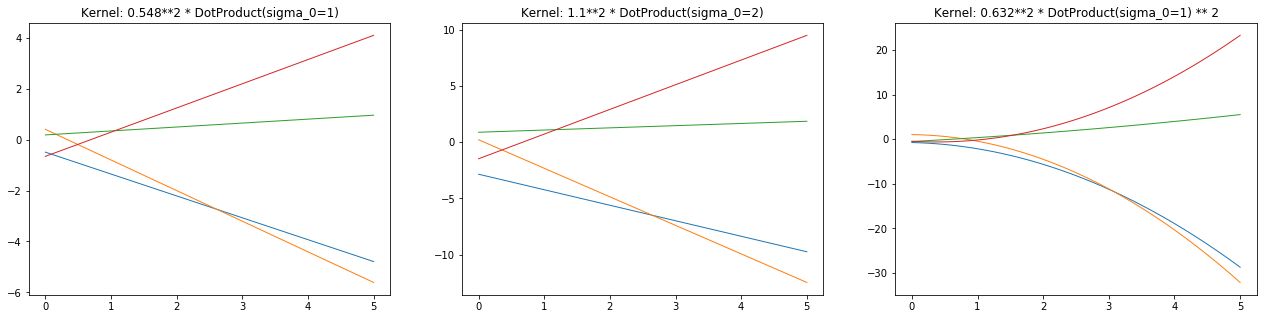

In [75]:
kernels = [0.3*DotProduct(sigma_0=1.0),
           1.2*DotProduct(sigma_0=2.0),
           0.4*DotProduct(sigma_0=1.0)**2
           ]
i=0
f,axarr = plt.subplots(1, 3,figsize=(22,5))
for fig_index, kernel in enumerate(kernels):
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Plot prior
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    y_samples = gp.sample_y(X_[:, np.newaxis], 4)
    axarr[i].plot(X_, y_samples, lw=1)
    #plt.xlim(0, 5)
    #plt.ylim(-5.5, 5.5)
    axarr[i].set_title("Kernel: "+str(kernel), fontsize=12)
    i+=1
plt.show()

**PERIODIC KERNEL**

This kernel is useful when data has periodicity, therefore it allows one to model functions which repeat themselves exactly. The expression is given by

\begin{align}
k_{Per}(x,x')=\sigma^{2}_{f} \exp(-\frac{2\sin^{2}(\pi \rvert x-x' \rvert /p)}{\ell^2})
\end{align}

Its parameters are easily interpretable:

- The period **p** simply determines the distance between repititions of the function.

- The lengthscale acts in the same way as in the SE kernel.

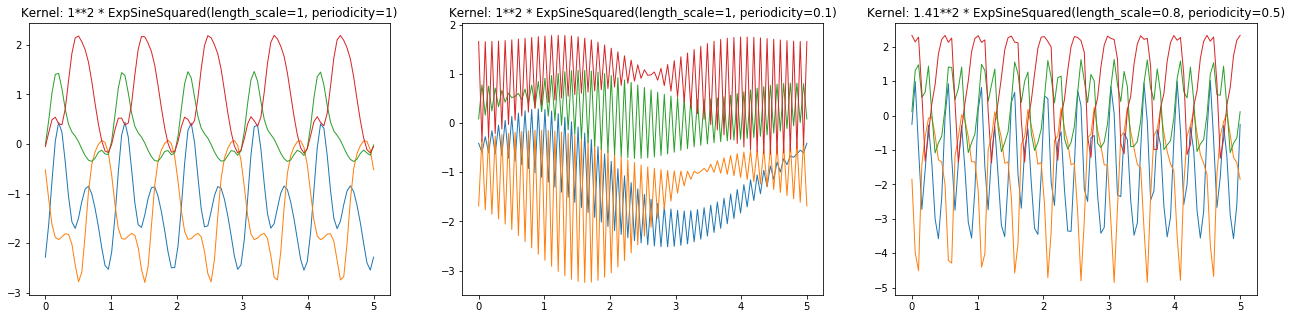

In [56]:
kernels = [1.0*ExpSineSquared(length_scale=1.0,periodicity=1.0),
           1.0*ExpSineSquared(length_scale=1.0,periodicity=0.1),
           2.0*ExpSineSquared(length_scale=0.8,periodicity=0.5)
           ]
i=0
f,axarr = plt.subplots(1, 3,figsize=(22,5))
for fig_index, kernel in enumerate(kernels):
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Plot prior
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    y_samples = gp.sample_y(X_[:, np.newaxis], 4)
    axarr[i].plot(X_, y_samples, lw=1)
    axarr[i].set_title("Kernel: "+str(kernel), fontsize=12)
    i+=1
plt.show()

**WHITE NOISE KERNEL**

The main use-case of this kernel is as part of a sum-kernel where it explains the noise-component of the signal. Tuning its parameter corresponds to estimating the noise-level.

\begin{align}
k(x,x')=\sigma^{2}_{f} \delta(x-x')
\end{align}

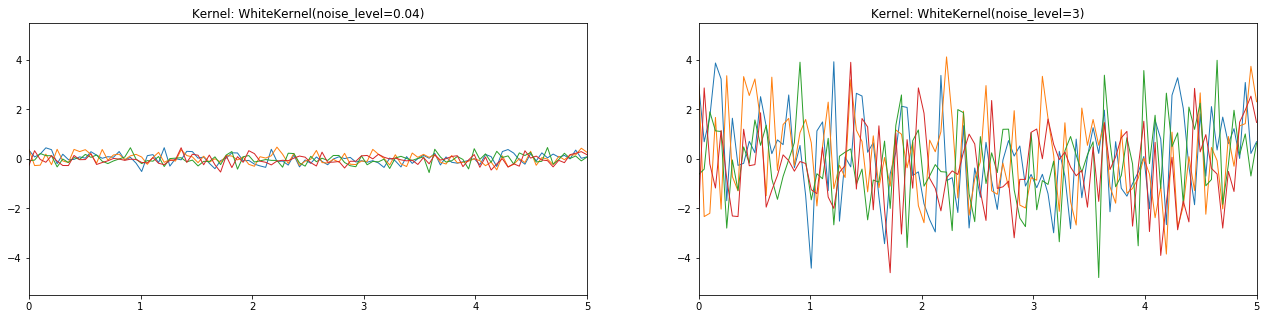

In [68]:
kernels = [WhiteKernel(noise_level=0.04),
           WhiteKernel(noise_level=3.0)
           ]
i=0
f,axarr = plt.subplots(1, 2,figsize=(22,5))
for fig_index, kernel in enumerate(kernels):
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Plot prior
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    y_samples = gp.sample_y(X_[:, np.newaxis], 4)
    axarr[i].plot(X_, y_samples, lw=1)
    axarr[i].set_xlim(0, 5)
    axarr[i].set_ylim(-5.5, 5.5)
    axarr[i].set_title("Kernel: "+str(kernel), fontsize=12)
    i+=1
plt.show()

## COMBINING KERNELS

The kernels above are useful if data is all the same type, however this is not a common situation. Therefore, we must provide solutions if the kind of structure of our data is not expressed by any known kernel.
The next few sections of this chapter will explore ways in which kernels can be combined to create new ones with different properties. This will allow us to include as much high- level structure as necessary into our models.

Although being many ways of combining kernel, such as convolution or tensor product, the more extended and the ones analyzed are addition and multiplication.


**Combining Kernels through multiplication**

Each kernel in a product modifies the resulting GP model in a consistent way. Thus, multiplying kernels is an efficient way to produce kernels combining several high-level properties. But what properties do these new kernels have? Here, we discuss a few examples.

- Multiplication by SE: Converts any global correlation structure into local correlation since SE(x, x′) decreases monotonically to 0 as |x − x′| increases. For example, Periodic kernel corresponds to exactly periodic structure, whereas Per × SE corresponds to locally periodic structure.
- Multiplicating Linear Kernels: By multiplying together n linear kernels, we obtain a prior on polynomials of degree n. 
- Multiplication by a linear kernel: It is equivalent to multiplying the function being modeled by a linear function. If f (x) ∼ GP(0, k) then x × f (x) ∼ GP(0, Lin × k), thus the marginal standard deviation of the function being modeled grows linearly away from the location given by kernel parameter c.

Examples of one-dimensional structures expressible by multiplying kernels. First row shows $k(x, x')$. The second one functions $f(x)$ sampled from GP prior.

<img src="prodkernels.PNG">

**Combining Kernels through sum**

Let $f_{a}, f_{b}$ be functions drawn independently from GP priors $ f_{a} \sim	 GP(\mu_{a}, k_{a})$ and $f_{b} \sim GP(\mu_{b}, k_{b})$. Then the distribution of the sum of those functions is simply another GP:

\begin{align}
f_{a} +f_{b} \sim GP(\mu_{a}+\mu_{b}, k_{a}+k_{b})
\end{align}


As it is easy to encode additivity into GP models, note that kernels $k_{a}$ and $k_{b}$ can be of different types, allowing us to model the data as a sum of independent functions, each possibly representing a wide range type of structures.


Examples of one-dimensional structures expressible by adding kernels. $SE_{long}$ denotes a SE kernel whose lengthscale is long relative to that of $SE_{Short}$.

<img src="sumkernels.PNG">

The code to generate that figures and the ones in included in combining kernels through multiplication is attached in another jupyter notebook.


## Model Selection and Adaptation of Hyperparameters

To estimate the kernel parameters, we could use exhaustive search over a discrete grid of values, with validation loss as an objective, but this can be quite slow. Here we consider an empirical Bayes approach, which will allow us to use continuous optimization methods, which are much faster. In particular, we will maximize the marginal likelihood 

\begin{align}
p(y \rvert X) = \int p(y \rvert f, X)p(f \rvert X)df
\end{align}

Since $p(f \rvert X) = 	\mathcal{N} (f \rvert 0, K)$ and $p (y \rvert f)= \prod_{i} \mathcal{N}(y_{i} \rvert f_{i}, \sigma^{2}_{y})$ the marginal likelihood is given by

\begin{align}
\log ((p(y \rvert X)) = \log \mathcal{N}(y \rvert 0, K_{y}) = -\frac{1}{2}yK^{-1}_{y}y-\frac{1}{2}\log  \rvert K_{y} \rvert-\frac{N}{2}\log(2\pi) 
\end{align}

where $K_{y}= K_{f} + \sigma^{2}_{n}I$ is the covariance matrix for the noisy targets \textbf{y} and $K_{f}$ is the covariance matrix for the noise-free latent f.


The first term of the marginal likelihood is a data fit term since it is the only one involving the observed targets. The second term, $\log \rvert K_{y}\rvert/2$, is the model complexity depending only on the covariance function and the inputs. Lastly, $\log(2\pi)/2 $ is just a normalization constant.

To understand the tradeoff between the first two terms, consider a 1-dimensional SE kernel, as we vary the length scale $\ell$ and hold $\sigma^{2}_{y}$ fixed. For short length scales, the fit will be good, so $\boldsymbol{y}K^{-1}_{y}\boldsymbol{y}$ will be small. However, the model complexity will be high: $\boldsymbol{K_{y}}$ will be almost diagonal, since most points will not be considered near any others, so the $\log \rvert \boldsymbol{K_{y}}\rvert $ will be large. For long length scales, the fit will be poor but the model complexity will be low: $\boldsymbol{K_{y}}$ will be almost all 1's so $\log \rvert \boldsymbol{K_{y}} \rvert$ will be small. 

Now, it is time to maximize the marginal likelihood in order to set the hyperparameters. We seek the partial derivatives of the marginal likelihood w.r.t the hyperparameters denoted by $\theta$. Using the rules of the matrix derivatives one can show that

\begin{align}
\frac{\partial}{ \partial \theta_{j}}\log p(y \rvert X, \theta ) = \frac{1}{2}y^{T}K^{-1}_{y}\frac{\partial K}{\partial \theta_{j}}K^{-	1}_{y}y-\frac{1}{2}tr(K^{-1}_{y}\frac{\partial K_{y}}{\partial \theta})= \frac{1}{2}tr\bigg( (\boldsymbol{\alpha \alpha^{T}}-K^{-1}_{y})\frac{\partial K_{y}}{\partial \theta_{j}}\biggr)
\end{align}  

where $\alpha = K^{-1}\boldsymbol{y}$. It takes $\mathcal{O}(n^{3})$ time to compute $K^{-1}_{y}$, and $\mathcal{O}(n^{2})$ time per hyperparameter to compute the gradient. Often there exists some constraints on the hyperparameters, such as $\sigma^{2}_{y} \geq 0$. In this case, we can define $\theta = \log(\sigma^{2}_{y})$, and then use the chain rule.

Although not being a devastating problem note that there is no guarantee that the marginal likelihood does not suffer from multiple local optima since the objective is not convex and every local maximum corresponds to a particular interpretation of the data. Hence, it is truly recommended to perform more than iteration.

Another way to fit the hyperparameters model is using the LOO-CV (leave one out cross validation) in the loss function for example the negative predictive log probabiity. (See Chapter 5 in Carl E. Rasmussen and Christopher K.I. Williams. Gaussian Processes for Machine Learning, volume 38. The MIT Press, Cambridge, MA, USA, 2006.]

## MAUNA LOA REGRESSION

After having explained how we can combine the different kernel in order to fit different kind of structures and how model selection and adaptation of hyperparameteres has to be done using marginal likelihood we should begin with the regression. 

Firstly, we plot the data in order to get a better insight of how it behaves and how we can build our kernel.


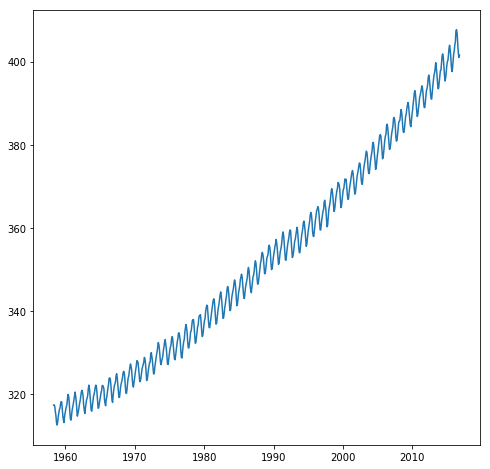

In [139]:
df = pd.read_csv('co2_mm_mlo_series.csv',delimiter=";")
data=df.values
x = data[:,0].astype(float)
y = data[:,1].astype(float)
x1= data[:,0].astype(float)/1000
y1= data[:,1].astype(float)
xfuture=np.zeros(20*12)
xfuture[0]=2016.792+0.08333333333333333
for i in range(1,20*12):
    xfuture[i]=xfuture[i-1]+0.08333333333333333
x_train = x1
y_train = y1
x_test=xfuture
x_train=x_train.reshape(-1,1)
y_train=y_train.reshape(-1,1)
plt.figure(figsize=(8,8))
plt.plot(x1,y1)
plt.show()

We modifiy the values of x-axis to state that the observations are monthly.

From the plot above we state that In our particular case Mauna Loa dataset presents a pronounced long term rising trend that we try to model using a squared exponential kernel with two hyperparameters controlling the variance $\theta_{1}$ and characterisitc length-scale $\theta_{2}$

\begin{align}
k_{1}(x,x')= \theta_{1} \exp \bigg(-\frac{(x-x')^{2}}{2\theta^{2}_{2}}\biggr)
\end{align}

The SE kernel with a large length-scale enforces this component to be smooth, note that it is not enforced that the trend is rising which leaves this choice to the GP.


On the other side, the seasonal component( caused by different concentrations of plants) seems also evident. We can use the periodic kernel with a fixed periodicity of 1 year. The length-scale $\theta_{5}$ of this periodic component, controlling its smoothness, is a free parameter and $\theta_{3}$ gives the magnitude. In order to allow decaying away from exact periodicity, the product with an SE kernel is taken. The length-scale $\theta_{4}$ of this SE component controls the decay time and is a further free parameter. 

\begin{align}
k_{2}(x,x')= \theta_{3}^{2} \exp \bigg(-\frac{(x-x')^{2}}{2\theta^{2}_{4}} - \frac{2 \sin^{2}(\pi(x-x'))}{\theta^{2}_{5}}\biggr)
\end{align}


In order to capture the medium term irregularities a rational quadratic term is used. These irregularities can better be explained by a Rational Quadratic than a SE kernel component, since it gives lower marginal likelihood as it can accommodate several length-scales.

\begin{align}
k_{3}(x,x')= \theta_{6}^{2} \bigg(1+\frac{(x-x')^{2}}{2\theta^{2}_{7}\theta_{8}}\biggr)^{-\theta_{8}}
\end{align}


As before $\theta_{6}$ is the variance, the length-scale $\theta_{7}$  and $\theta_{8}$ (also known as $\alpha$ parameter, which determines the diffuseness of the length-scales) are to be determined. 


The last feature to model, the noise term, has been specified using an SE kernel, which explains the correlated noise components such as local weather phenomena, and a White Noise kernel. 

\begin{align}
k_{4}(x,x')= \theta_{9}^{2} \exp \bigg(-\frac{(x-x')^{2}}{2\theta^{10}_{2}}\biggr)+\theta_{11}^{2}\delta_{pq}
\end{align}


where $\theta_{9}$ is the magnitude of the correlated noise component, $\theta_{10}$ is its length-scale and $\theta_{11}$ is the variance of the independent noise component.


To sum up, the final covariance function is 

\begin{align}
k(x,x')= k_{1}(x,x')+k_{2}(x,x')+k_{3}(x,x')+k_{4}(x,x')
\end{align}

with hyperparameters $\boldsymbol{\theta} = (\theta_{1}, \cdots, \theta_{11})^{T}$.

Let's build that covariance function with some intial values for the hyperparameters.

In [140]:
# Kernel with parameters randomly initialized 
k1 = 53.0**2 * RBF(length_scale=22.0)  # long term smooth rising trend
k2 = 1**2 * RBF(length_scale=25.0) \
    * ExpSineSquared(length_scale=1, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.5**2 \
    * RationalQuadratic(length_scale=1., alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpml = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=2, normalize_y=True)

Let's fit the model:

In [122]:
gp.fit(x_train,y_train)

GaussianProcessRegressor(alpha=0, copy_X_train=True,
             kernel=53**2 * RBF(length_scale=22) + 1**2 * RBF(length_scale=25) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=0.5, length_scale=1) + 0.5**2 * RBF(length_scale=0.3) + WhiteKernel(noise_level=0.04),
             n_restarts_optimizer=2, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

To fit the hyperparameters by optimizing the marginal likelihood we use a conjugate gradient optimitzer as BFGS. The Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm is an iterative method for solving unconstrained nonlinear optimization problems. At the same time in order to avoid local minime  we restart the optimizer more than 1 time.

In [123]:
print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

GPML kernel: 60.6**2 * RBF(length_scale=35.7) + 2.91**2 * RBF(length_scale=207) * ExpSineSquared(length_scale=1.47, periodicity=1) + 0.64**2 * RationalQuadratic(alpha=0.474, length_scale=1.14) + 0.199**2 * RBF(length_scale=0.115) + WhiteKernel(noise_level=0.0369)
Log-marginal-likelihood: -163.542


In [124]:
#y_val,sigma1=gp.predict(x_train[-40:].reshape(-1,1), return_std=True)
#score=metrics.r2_score(y_train[-40:], y_val)
#print(score)
y_pred, sigma = gp.predict(x_test.reshape(-1,1), return_std=True)

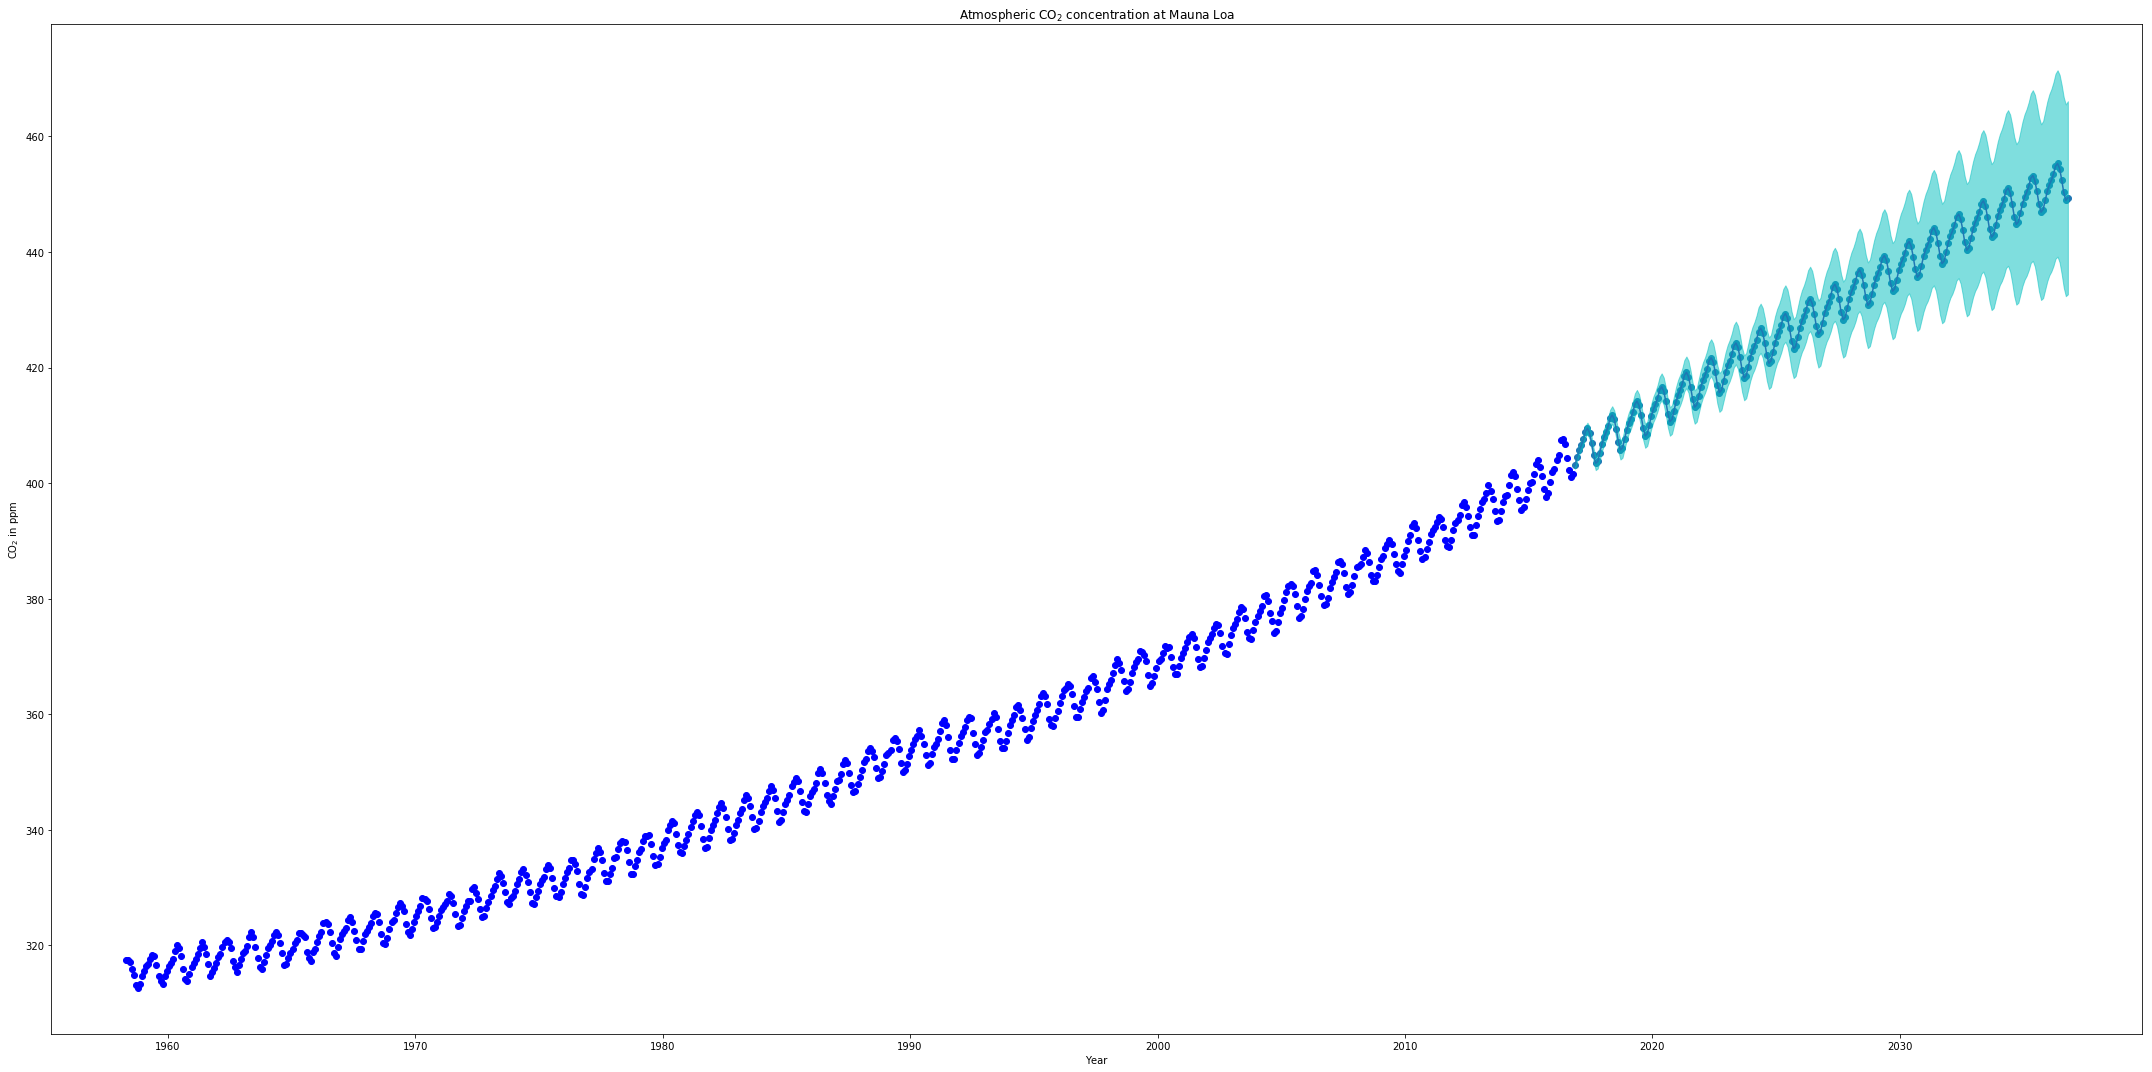

In [125]:
plt.figure(figsize=(30,15))
plt.scatter(x_train, y_train, c='b')
plt.scatter(x_test,y_pred)
plt.plot(x_test,y_pred)
plt.fill_between(x_test, y_pred[:,0]-1.96*sigma, y_pred[:,0] + \
                 1.96*sigma,alpha=0.5,color='c')
plt.xlim(x_train.min()-3, x_test.max()+3)
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()

The plot above shows the underlying function together with 95% predictive confidence region for predictions for the next 20 years. The confidence interval gets wider as the time increases. 

On the other hand below we show the decomposition into additive components. Note that some components capture slowly-changing structure while others capture quickly-varying structure.

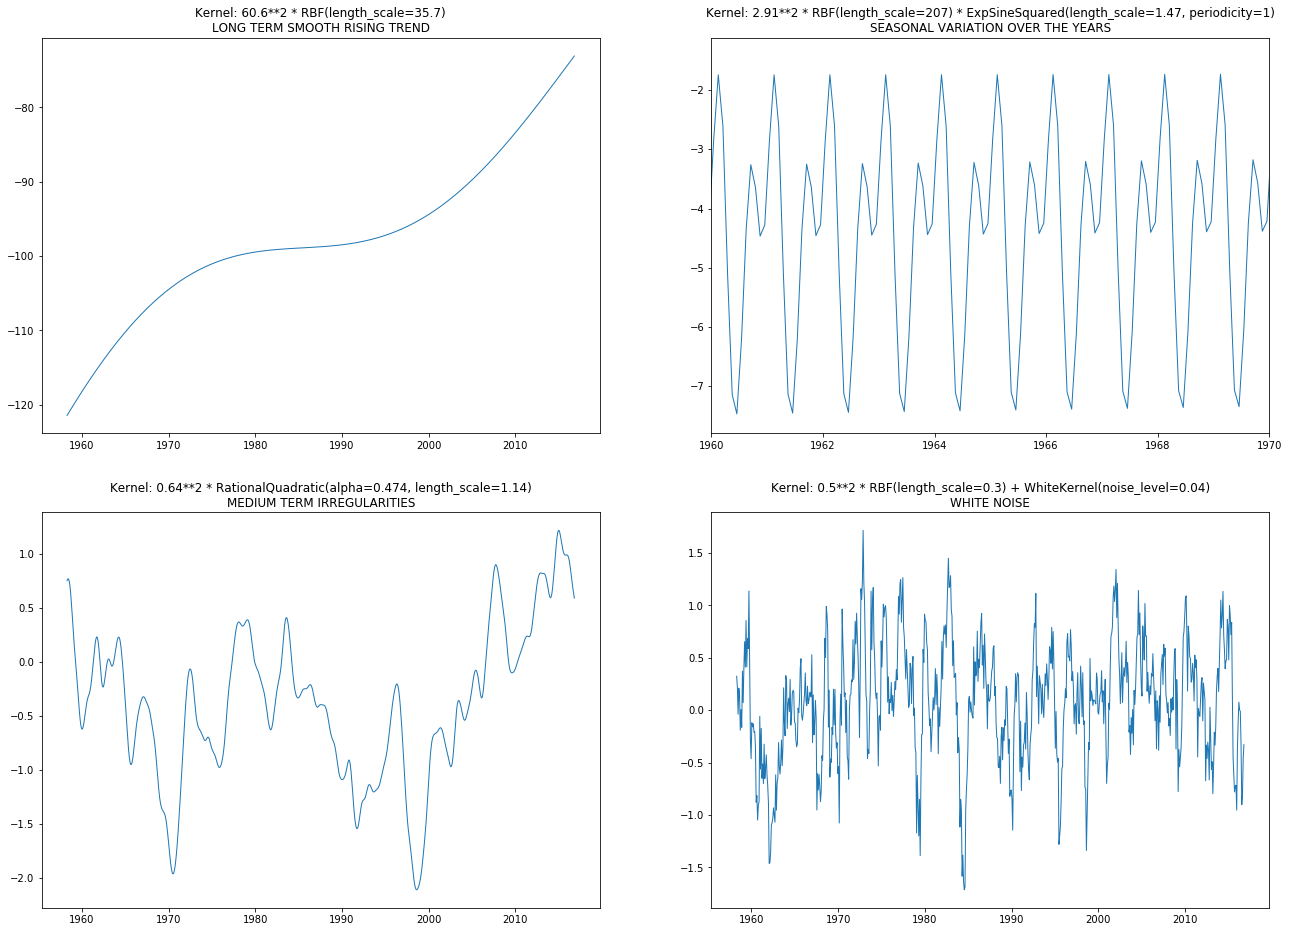

In [127]:
kernels = [60.6**2 * RBF(length_scale=35.7),
           2.91**2 * RBF(length_scale=207) * ExpSineSquared(length_scale=1.47, periodicity=1),
           0.64**2 * RationalQuadratic(alpha=0.474, length_scale=1.14),
          0.5**2 * RBF(length_scale=0.3) + WhiteKernel(noise_level=0.04)]
i=0
propierty=['LONG TERM SMOOTH RISING TREND','SEASONAL VARIATION OVER THE YEARS','MEDIUM TERM IRREGULARITIES',
           'WHITE NOISE']
f,axarr = plt.subplots(2, 2,figsize=(22,16))
for fig_index, kernel in enumerate(kernels):
    if i==0 or i==2:
        l=0;
    else: l=1;
    if i==0 or i==1:
        o=0;
    else:o=1;
    gp = GaussianProcessRegressor(kernel=kernel)
    # Plot prior
    #plt.figure(fig_index, figsize=(8, 8))
    X_ = x_train
    y_samples = gp.sample_y(X_,1)
    y_mean, y_std = gp.predict(X_, return_std=True)
    y_samples = gp.sample_y(X_, 1)
    if i==1:
        axarr[o, l].set_xlim([1960,1970])
    axarr[o, l].plot(X_, y_samples, lw=1)
    axarr[o, l].set_title("Kernel: "+str(kernel)+'\n'+str(propierty[i]), fontsize=12)
    i+=1
plt.show()

Further experiments in the Mauna Loa regression problem can be experimenting using cross validation or another set of kernels.